<a href="https://colab.research.google.com/github/ZhanarBaken/data_science_sf/blob/main/practical_work_ml7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Прогнозирование биологического ответа

Практика основана на соревновании
[Kaggle: Predicting a Biological Response](https://www.kaggle.com/c/bioresponse "Необязательная подсказка")

In [ ]:
## Устанавливаем библиотеки
!pip3 install hyperopt
!pip3 install optuna

In [3]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

#делаем импорт библиотеки гипепараметров
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

%matplotlib inline
plt.style.use('seaborn')

In [4]:
#зафиксируем random_state 
random_state = 42

## <center> Описание задачи

Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

## <center> Знакомство с данными

In [5]:
#ЕСЛИ РАБОТАЕМ В IDE
#data = pd.read_csv('data/_train_sem09 (1).csv')

#ЕСЛИ РАБОТАЕМ В GOOGLE COLAB
# подключаем google диск, где у нас хранятся данные
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('./drive/MyDrive/SF_DS/data/_train_sem09 (1).csv')
data.head()

Mounted at /content/drive


,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [6]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

## <center> **Логистическая регрессия**

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [ ]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = log_reg.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = log_reg.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.89
Test: 0.78


### Оптимизация гиперпараметров модели

#### **GridSearchCV**

In [ ]:
param_grid = [
              {'penalty': ['l2', 'none'] , 
              'solver': ['lbfgs', 'sag'], 
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, 
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=random_state, 
        max_iter=1000
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
#Выводим значения метрики 
y_train_pred = grid_search.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

CPU times: user 15.3 s, sys: 1.74 s, total: 17 s
Wall time: 53min 1s
Train: 0.85
Test: 0.79


In [ ]:
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

Наилучшая модель:
LogisticRegression(C=0.1, max_iter=1000, random_state=42, solver='liblinear')
Наилучшее значение точности при кросс-валидаци: 0.76


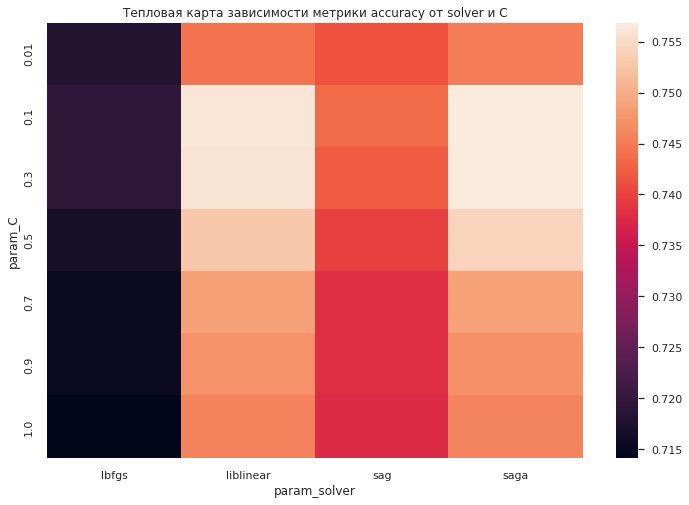

In [ ]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С')
sns.set(rc={'figure.figsize':(12, 8)}) 

Видим, что слабая регуляризация С = 0,01 отрицательно влияет на метрику, поэтому есть смысл брать значения больше 0,1 и  алгоритмы оптимизации liblinear и saga работают лучше.

####  **RandomizedSearchCV**

In [64]:
param_distributions = {'penalty': ['l1', 'l2', 'none'] ,
                      'solver': ['lbfgs', 'sag', 'liblinear', 'saga'],
                       'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 50, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
#Выводим значения метрики 
y_train_pred = random_search.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
80 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 464, in _check_solver
    raise ValueError("penalty='none' is n

CPU times: user 1min 56s, sys: 1.95 s, total: 1min 58s
Wall time: 1h 11min 52s
Train: 0.84
Test: 0.79


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [67]:
print("Наилучшая модель:\n{}".format(random_search.best_estimator_))
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(random_search.best_score_))

Наилучшая модель:
LogisticRegression(C=0.34, max_iter=1000, penalty='l1', random_state=42,
                   solver='saga')
Наилучшее значение точности при кросс-валидаци: 0.76


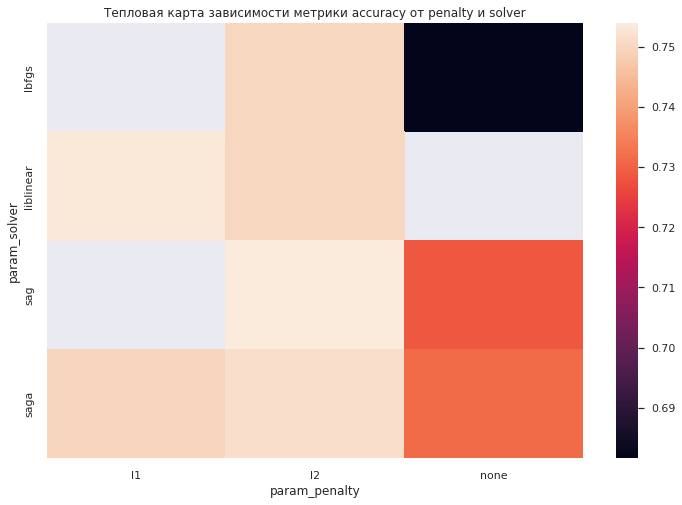

In [77]:
# отрисуем, как менялась точность при penalty и С гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(random_search.cv_results_),
                        values='mean_test_score', index='param_solver',
                        columns='param_penalty')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от penalty и solver')
sns.set(rc={'figure.figsize':(12, 8)}) 

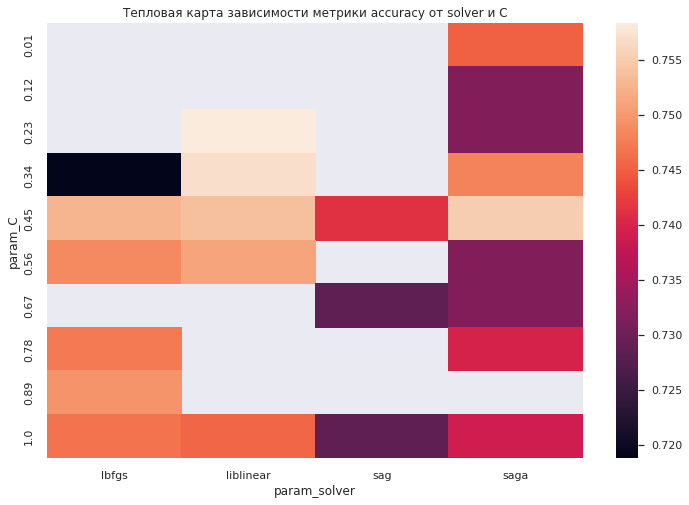

In [75]:
# отрисуем, как менялась точность при solver и С гиперпараметрах
visual_solver = pd.pivot_table(pd.DataFrame(random_search.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual_solver)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С')
sns.set(rc={'figure.figsize':(12, 8)}) 

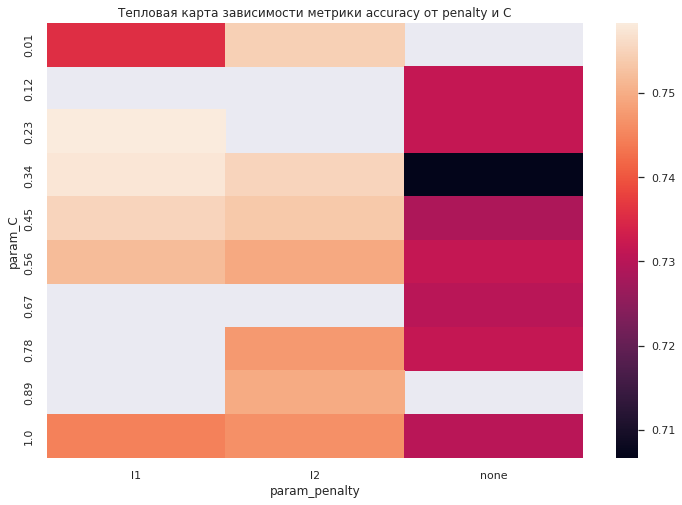

In [76]:
# отрисуем, как менялась точность при penalty и С гиперпараметрах
visual_pen = pd.pivot_table(pd.DataFrame(random_search.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_penalty')
sns.heatmap(visual_pen)
plt.title('Тепловая карта зависимости метрики accuracy от penalty и С')
sns.set(rc={'figure.figsize':(12, 8)}) 

#### **Hyperopt**

In [8]:
# зададим пространство поиска гиперпараметров
penalty_list = ['l1', 'l2']
solver_list = ['liblinear', 'saga']
max_iter_list = list(range(1000, 2000))

space_log = {'penalty': hp.choice('penalty', penalty_list) ,
              'solver': hp.choice('solver', solver_list),
              'C': hp.uniform('C',  low=0.01, high=1),  
              'max_iter' : hp.choice('max_iter', max_iter_list)
              }  

def hyperopt_log(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'], 
              'solver': params['solver'], 
              'C': float(params['C']),
              'max_iter': int(params['max_iter']),
              }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)

    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [10]:
%%time
# начинаем подбор гиперпараметров

trials_log = Trials() # используется для логирования результатов

best_log=fmin(hyperopt_log, 
              space=space_log, 
              algo=tpe.suggest,
              max_evals=20, 
              trials=trials_log, 
              rstate=np.random.RandomState(random_state)
              )
print("Наилучшие значения гиперпараметров {}".format(best_log))

 90%|█████████ | 18/20 [28:15<01:28, 44.11s/it, best loss: -0.7827340480849463]

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 20/20 [40:35<00:00, 121.77s/it, best loss: -0.7827340480849463]
Наилучшие значения гиперпараметров {'C': 0.1203395842127653, 'max_iter': 396, 'penalty': 0, 'solver': 0}
CPU times: user 8min 25s, sys: 2.49 s, total: 8min 27s
Wall time: 40min 35s


In [41]:
  # перезапишем параметры 
  best_max_iter = max_iter_list[best_log['max_iter']]
  best_penalty = penalty_list[best_log['penalty']]
  best_solver = solver_list[best_log['solver']]
  
  print(f"Наилучшие значения гиперпараметров:\n\
  'C': {best_log['C']},  'max_iter':{best_max_iter}, \
  'penalty':'{best_penalty}', 'solver':'{best_solver}'")

Наилучшие значения гиперпараметров:
'C': 0.1203395842127653,  'max_iter':1396, 'penalty':'l1', 'solver':'liblinear'


In [35]:
# рассчитаем точность для тестовой выборки
log_reg_hyp = linear_model.LogisticRegression(
    random_state=random_state, 
    C=float(best_log['C']),
    max_iter=best_max_iter,
    penalty=best_penalty,
    solver=best_solver
)

log_reg_hyp.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = log_reg_hyp.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = log_reg_hyp.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.81
Test: 0.78


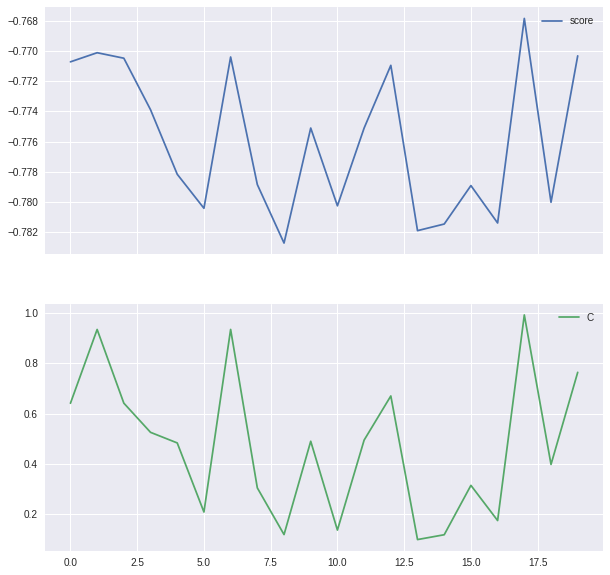

In [17]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['C'][0]] for x in trials_log.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'C'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

#### **Optuna**

Настроим оптимизацию гиперпараметров для логистической регрессии.

In [ ]:
def optuna_log(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
  solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
  C = trial.suggest_float('C', low=0.01, high=1)
  max_iter = trial.suggest_uniform('max_iter',low=1000,high=2000)

  # создаем модель
  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [ ]:
%%time
# cоздаем объект исследования 
study_log = optuna.create_study(study_name="LogisticRegression", \
                                      direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_log.optimize(optuna_log, n_trials=20)
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_log.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_log.best_value))

[I 2023-02-21 05:32:07,008] A new study created in memory with name: LogisticRegression
<ipython-input-32-1c7b7877a17c>:6: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[I 2023-02-21 05:32:17,268] Trial 0 finished with value: 0.8150602409638554 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.19542684036499414, 'max_iter': 1580.3079216776237}. Best is trial 0 with value: 0.8150602409638554.
<ipython-input-32-1c7b7877a17c>:6: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

[I 2023-02-21 

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.9936725568013539, 'max_iter': 1994.3496873518216}
f1_score на обучающем наборе: 0.89
CPU times: user 2min 5s, sys: 2.05 s, total: 2min 7s
Wall time: 2min 11s


In [ ]:
# рассчитаем точность для тестовой выборки
log_optuna = linear_model.LogisticRegression(**study_log.best_params,
                                             random_state=random_state, )
%time log_optuna.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = log_optuna.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = log_optuna.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

CPU times: user 628 ms, sys: 8.75 ms, total: 637 ms
Wall time: 649 ms
Train: 0.88
Test: 0.79


**Видим, что Optuna также удалось увеличить метрику, но за меньшее время, чем Hyperopt.**

График истории оптимизации - отображает количество испытаний на оси Х и метрику на оси Y.

Проверим, идет ли оптимизация гиперпараметров в правильном направлении или нет.

In [ ]:
optuna.visualization.plot_optimization_history(study_log, target_name="f1_score")

Все идет верно, метрика максимизируется.

График важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию/максимизацию метрики.

In [ ]:
optuna.visualization.plot_param_importances(study_log, target_name="f1_score")


Из этого графика можно сделать вывод, что стоит обратить большее внимание на настройку гиперпараметра С.

График контура отношений гиперпараметров. Он показывает связь между различными комбинациями гиперпараметров и значение метрики для этих комбинаций в виде контурного графика.

In [ ]:
optuna.visualization.plot_contour(study_log, params=["max_iter", "C"],
                                  target_name="f1_score")

Точки с темно-синем фоном это и есть лучшии комбинации C, max_iter (шкала может быть инвертирована).

### **Вывод**

**Сравнительная таблица способов оптимизации гиперпараметров**

| type | f1_score | best params | time| 
| ------- | -------- | ------- | -----
| ____                  | Train:0.89 Test: 0.78 |_____________________                           |____
| **GridSearchCV**      | Train:0.85  Test: 0.79| C=0.1, max_iter=1000, solver=liblinear                                | 53min 1s
| **RandomizedSearchCV**| Train:0.84  Test: 0.79| C=0.34, max_iter=1000, solver=saga, penalty='l1'                       | 1h 11min 52s
| **Hyperopt**          | Train:0.81  Test: 0.78| C~0.12, max_iter=1396 , solver=liblinear, penalty=l1                  | 40min 35s
| **Optuna**            | Train:0.88  Test: 0.79| C~0.99, max_iter=1994, solver=liblinear, penalty=l2                    | 2min 11s

**В GridSearchCV и RandomizedSearchCV были переданы одинаковые гиперпараметры,
но RandomizedSearchCV дольше работала по каким-то причинам? Если посомтреть на тепловые карты, то видно из-за того что она пропустила некоторые параметры в пересечение с другими она выбрала не самый лучший варинат, все таки liblinear  лучше чем saga.**

**В Hyperopt и Optuna было передано одинаковые гиперпараметры, если сравнить их по score, то тут спорно какой метод работает лучше, но по времени Optuna выигрывает всех.**

**Считаю, что Hyperopt лучше всего справился, потому что разница между обучающим score и валидационным score меньше всего и время было затрачено в среднем намного меньше, если учесть, что в него было передано намного больше комбинации гипрепараметров чем в GridSearchCV и RandomizedSearchCV.**

## <center> **Случайный лес**

Проделаем аналогичное для RandomForestClassifier().
Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [ ]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.81


### Оптимизация гиперпараметров модели

#### **GridSearchCV**

In [19]:
%%time 
param_grid = {'n_estimators': list(range(100, 200, 30)),
              'min_samples_leaf': [5, 6, 7, 8],
              'max_depth': list(np.linspace(10, 40, 5, dtype=int))
              }
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  

grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

f1_score на обучающем наборе: 0.93
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'max_depth': 25, 'min_samples_leaf': 7, 'n_estimators': 130}
CPU times: user 7.16 s, sys: 498 ms, total: 7.66 s
Wall time: 9min 40s


In [20]:
print("Наилучшая модель:\n{}".format(grid_search_forest.best_estimator_))
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search_forest.best_score_))

Наилучшая модель:
RandomForestClassifier(max_depth=25, min_samples_leaf=7, n_estimators=130,
                       random_state=42)
Наилучшее значение точности при кросс-валидаци: 0.78


In [21]:
# Взглянем на результаты кросс-валидации
result_cv = pd.DataFrame(grid_search_forest.cv_results_)
result_cv.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.843797,0.255130,0.067547,0.012951,10,5,100,"{'max_depth': 10, 'min_samples_leaf': 5, 'n_es...",0.760000,0.775000,0.781667,0.763333,0.755,0.767000,0.009854,80
1,2.631525,0.627204,0.104244,0.048762,10,5,130,"{'max_depth': 10, 'min_samples_leaf': 5, 'n_es...",0.766667,0.771667,0.781667,0.773333,0.750,0.768667,0.010509,79


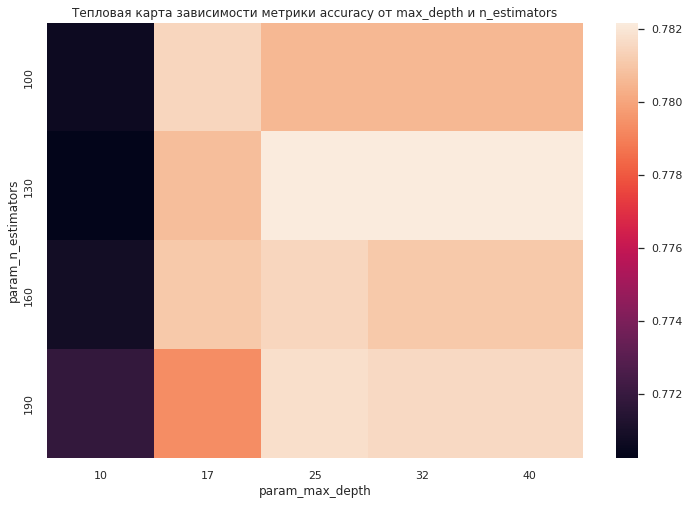

In [22]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_forest.cv_results_),
                         values='mean_test_score', index='param_n_estimators',
                        columns='param_max_depth')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от max_depth и n_estimators')
sns.set(rc={'figure.figsize':(12, 8)}) 

####  **RandomizedSearchCV**

In [14]:
%%time 
param_distributions = {'n_estimators': list(range(100, 200, 10)),
              'min_samples_leaf': [5, 6, 7, 8],
              'max_depth': list(np.linspace(10, 40, 5, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

f1_score на обучающем наборе: 0.93
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'n_estimators': 180, 'min_samples_leaf': 6, 'max_depth': 40}
CPU times: user 3.94 s, sys: 94.8 ms, total: 4.04 s
Wall time: 1min 26s


In [15]:
print("Наилучшая модель:\n{}".format(random_search_forest.best_estimator_))
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(random_search_forest.best_score_))

Наилучшая модель:
RandomForestClassifier(max_depth=40, min_samples_leaf=6, n_estimators=180,
                       random_state=42)
Наилучшее значение точности при кросс-валидаци: 0.78


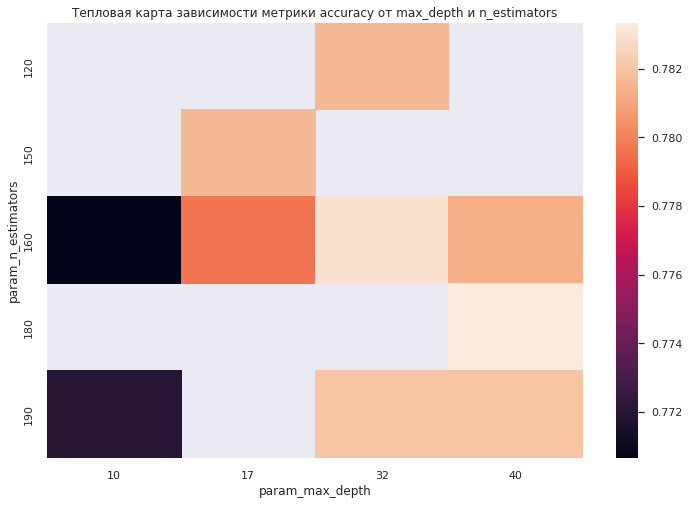

In [17]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(random_search_forest.cv_results_),
                         values='mean_test_score', index='param_n_estimators',
                        columns='param_max_depth')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от max_depth и n_estimators')
sns.set(rc={'figure.figsize':(12, 8)}) 

#### **Hyperopt**

In [ ]:
# зададим пространство поиска гиперпараметров
space_rf={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 10, 40, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 5, 10, 1)
      }
      
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)

    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [ ]:
# начинаем подбор гиперпараметров
%%time

trials_rf = Trials() 

best_rf=fmin(hyperopt_rf, 
          space=space_rf, 
          algo=tpe.suggest,
          max_evals=20, 
          trials=trials_rf, 
          rstate=np.random.RandomState(random_state)
         )
print("Наилучшие значения гиперпараметров {}".format(best_rf))

100%|██████████| 20/20 [04:10<00:00, 12.55s/it, best loss: -0.8009054214769276]
Наилучшие значения гиперпараметров {'max_depth': 25.0, 'min_samples_leaf': 7.0, 'n_estimators': 188.0}
CPU times: user 53.3 s, sys: 917 ms, total: 54.2 s
Wall time: 4min 10s


In [ ]:
# рассчитаем точность для тестовой выборки
rf_hyp = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best_rf['n_estimators']),
    max_depth=int(best_rf['max_depth']),
    min_samples_leaf=int(best_rf['min_samples_leaf'])
)
%time rf_hyp.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf_hyp.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf_hyp.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


CPU times: user 2.91 s, sys: 8.61 ms, total: 2.92 s
Wall time: 2.92 s
Train: 0.93
Test: 0.82


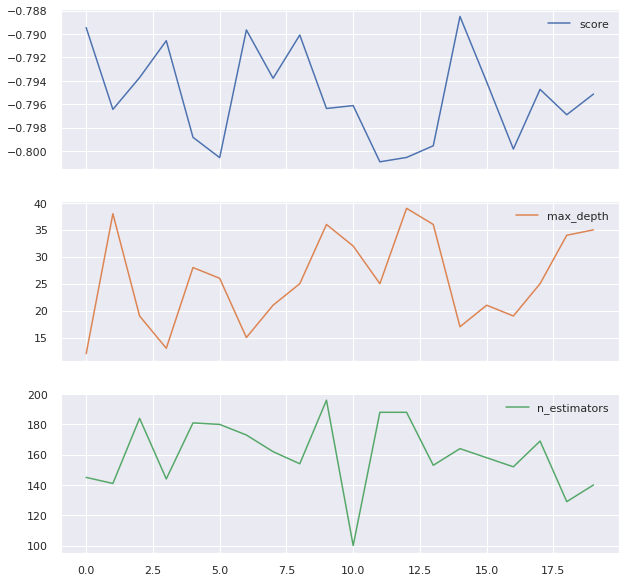

In [ ]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials_rf.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

#### **Optuna**

Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [ ]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score
  

In [ ]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_rf = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_rf.optimize(optuna_rf, n_trials=20)
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_rf.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_rf.best_value))

[I 2023-02-21 09:37:04,563] A new study created in memory with name: RandomForestClassifier
[I 2023-02-21 09:37:07,025] Trial 0 finished with value: 0.8897058823529412 and parameters: {'n_estimators': 123, 'max_depth': 13, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8897058823529412.
[I 2023-02-21 09:37:08,818] Trial 1 finished with value: 0.9043848964677224 and parameters: {'n_estimators': 113, 'max_depth': 18, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.9043848964677224.
[I 2023-02-21 09:37:11,318] Trial 2 finished with value: 0.8998468606431853 and parameters: {'n_estimators': 160, 'max_depth': 19, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.9043848964677224.
[I 2023-02-21 09:37:13,908] Trial 3 finished with value: 0.8996328029375764 and parameters: {'n_estimators': 152, 'max_depth': 18, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.9043848964677224.
[I 2023-02-21 09:37:16,729] Trial 4 finished with value: 0.9263351749539595 and parameters: {

Наилучшие значения гиперпараметров {'n_estimators': 164, 'max_depth': 32, 'min_samples_leaf': 5}
f1_score на обучающем наборе: 0.95
CPU times: user 57.9 s, sys: 144 ms, total: 58 s
Wall time: 58.8 s


In [ ]:
# рассчитаем точность для тестовой выборки
rf_optuna = ensemble.RandomForestClassifier(**study_rf.best_params,\
                                            random_state=random_state, )
%time rf_optuna.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf_optuna.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf_optuna.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

CPU times: user 2.69 s, sys: 7.55 ms, total: 2.7 s
Wall time: 2.69 s
Train: 0.95
Test: 0.83


**Видим, что Optuna также удалось увеличить метрику, но за меньшее время, чем Hyperopt.**

In [ ]:
optuna.visualization.plot_optimization_history(study_rf, target_name="f1_score")

Все идет верно, метрика максимизируется.

In [ ]:
optuna.visualization.plot_param_importances(study_rf, target_name="f1_score")


Из этого графика можно сделать вывод, что стоит обратить большее внимание на настройку гиперпараметра min_samples_leaf.

Так же, построим график контура отношений гиперпараметров.

In [ ]:
optuna.visualization.plot_contour(study_rf, params=["n_estimators", "max_depth"],
                                  target_name="f1_score")

Точки с темно-синем фоном это и есть лучшии комбинации n_estimators, max_depth (шкала может быть инвертирована).

### **Вывод**


**Сравнительная таблица способов оптимизации гиперпараметров**

| type | f1_score | best params | time| 
| ------- | -------- | ------- | -----
| ____                  | Train:1.00 Test: 0.81 |_____________________                           |____
| **GridSearchCV**      | Train:0.93  Test: 0.82| n_estimators = 130, max_depth = 25, min_samples_leaf = 7            | 9min 40s
| **RandomizedSearchCV**| Train:0.93  Test: 0.82| n_estimators = 180, max_depth = 40, min_samples_leaf = 6            | 1min 26s
| **Hyperopt**          | Train:0.93  Test: 0.82| n_estimators = 188, max_depth = 25, min_samples_leaf = 7            | 4min 10s
| **Optuna**            | Train: 0.95 Test: 0.83| n_estimators = 164, max_depth = 32, min_samples_leaf = 5            | 58.8 s

**В GridSearchCV и RandomizedSearchCV были переданы одинаковые гиперпараметры,
но RandomizedSearchCV удалось добиться тех же результатов почти в 7 раз быстрее. Оба метода улучшили basline score.**

**В Hyperopt и Optuna так же было передано одинаковые гиперпараметры, снова спорно какой метод выдает лучше результат, но по времени Optuna выигрывает снова.**

**Считаю, что снова Hyperopt лучше всего справился, потому что параметр min_samples_leaf=7, больше чем в RandomizedSearchCV и Optuna, а значит меньше шансов переобучится, и время было затрачено в среднем не много, если учесть, что в него было передано намного больше комбинации гипрепараметров чем в GridSearchCV, где так же min_samples_leaf=7.**